In [ ]:
# Εγκατάσταση της βιβλιοθήκης liac-arff για τη διαχείριση αρχείων ARFF
%pip install liac-arff

# Εισαγωγή των απαραίτητων βιβλιοθηκών
from google.colab import files # Για την αποστολή αρχείων μέσω Colab
import arff # Για τη διαχείριση αρχείων ARFF
import numpy as np # Για αριθμητικές πράξεις και πίνακες
import pandas as pd # Για διαχείριση δεδομένων με DataFrame
from sklearn.preprocessing import LabelEncoder, MinMaxScaler # Για την επεξεργασία δεδομένων
from sklearn.model_selection import train_test_split, cross_val_score # Για το διαχωρισμό δεδομένων και διασταυρωμένη επικύρωση
from sklearn.tree import DecisionTreeClassifier # Αλγόριθμος δέντρου αποφάσεων
from sklearn.neighbors import KNeighborsClassifier # Αλγόριθμος k-NN
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # Αξιολόγηση απόδοσης
import matplotlib.pyplot as plt # Για οπτικοποιήσεις
import seaborn as sns # Για προχωρημένες οπτικοποιήσεις

# Ζητά από τον χρήστη να ανεβάσει αρχεία
print("Ανέβασε τα δύο αρχεία ARFF σου:")
uploaded = files.upload() # Εμφανίζει παράθυρο για την αποστολή αρχείων

# Ελέγχει αν ανέβηκαν δύο αρχεία
if len(uploaded) != 2:
    print("Παρακαλώ ανέβασε ακριβώς 2 αρχεία.") # Μήνυμα σφάλματος αν ανέβουν λιγότερα/περισσότερα
else:
    datasets = {} # Λεξικό για αποθήκευση των δεδομένων κάθε αρχείου

    # Διαβάζει κάθε αρχείο ARFF που ανέβηκε
    for filename in uploaded.keys():
        print(f"Διαβάζω το αρχείο: {filename}")
        with open(filename, 'r') as file:
            data = arff.load(file) # Φορτώνει τα δεδομένα από το αρχείο
            datasets[filename] = data # Αποθήκευση στο λεξικό
            print("Μεταδεδομένα:", data['attributes']) # Εμφάνιση των μεταδεδομένων
            print("Δείγμα δεδομένων:", data['data'][:5]) # Εμφάνιση ενός δείγματος δεδομένων

    # Επεξεργασία κάθε αρχείου
    processed_datasets = {} # Λεξικό για επεξεργασμένα datasets
    for filename, data in datasets.items():
        print(f"\n--- Επεξεργασία του αρχείου: {filename} ---")

        # Μετατρέπει τα δεδομένα σε pandas DataFrame για ευκολότερη επεξεργασία
        columns = [attr[0] for attr in data['attributes']] # Ανάκτηση ονομάτων στηλών από τα μεταδεδομένα
        df = pd.DataFrame(data['data'], columns=columns) # Δημιουργία DataFrame

        # Αφαιρεί ελλιπή δεδομένα
        print("Αρχικό μέγεθος:", df.shape) # Εμφάνιση του αρχικού αριθμού γραμμών και στηλών
        df.replace('?', np.nan, inplace=True) # Αντικατάσταση των '?' με NaN
        df.dropna(inplace=True) # Αφαίρεση γραμμών που περιέχουν NaN
        print("Μέγεθος μετά την αφαίρεση ελλιπών:", df.shape) # Νέο μέγεθος δεδομένων

        # Κωδικοποίηση κατηγορικών δεδομένων σε αριθμητικές τιμές
        label_encoders = {} # Λεξικό για αποθήκευση των LabelEncoders
        for column in df.select_dtypes(include=['object']).columns: # Για κάθε κατηγορική στήλη
            le = LabelEncoder() # Δημιουργία LabelEncoder
            df[column] = le.fit_transform(df[column]) # Κωδικοποίηση της στήλης
            label_encoders[column] = le # Αποθήκευση του encoder για μελλοντική χρήση
        print("Μετά την κωδικοποίηση:", df.head()) # Εμφάνιση πρώτων γραμμών μετά την κωδικοποίηση

        # Κανονικοποίηση αριθμητικών δεδομένων σε [0, 1]
        scaler = MinMaxScaler() # Δημιουργία MinMaxScaler
        df[df.columns] = scaler.fit_transform(df[df.columns]) # Εφαρμογή κανονικοποίησης
        print("Μετά την κανονικοποίηση:", df.head()) # Εμφάνιση πρώτων γραμμών μετά την κανονικοποίηση

        # Αποθήκευση του επεξεργασμένου dataset
        processed_datasets[filename] = df # Προσθήκη του DataFrame στο λεξικό

    # Εφαρμογή αλγορίθμων Decision Tree και k-NN
    for filename, df in processed_datasets.items():
        print(f"\n--- Εκπαίδευση και Αξιολόγηση για το αρχείο: {filename} ---")

        # Διαχωρίζει τα χαρακτηριστικά (X) και τον στόχο (y)
        X = df.iloc[:, :-1].values # Όλα τα χαρακτηριστικά
        y = df.iloc[:, -1].values # Η τελευταία στήλη είναι ο στόχος

        # Εκπαίδευση και αξιολόγηση Decision Tree με Cross-Validation
        print("\n--- Απόδοση Decision Tree με Cross-Validation ---")
        dt_model = DecisionTreeClassifier(random_state=1) # Δημιουργία μοντέλου Decision Tree
        dt_scores = cross_val_score(dt_model, X, y, cv=10, scoring='accuracy') # Εφαρμογή Cross-Validation
        print("Ακρίβειες ανά fold:", dt_scores) # Εμφάνιση ακρίβειας για κάθε fold
        print("Μέση Ακρίβεια:", dt_scores.mean()) # Εμφάνιση μέσης ακρίβειας
        print("Τυπική Απόκλιση:", dt_scores.std()) # Εμφάνιση τυπικής απόκλισης

        # Εκπαίδευση και αξιολόγηση k-NN με Cross-Validation
        print("\n--- Απόδοση k-NN με Cross-Validation ---")
        knn_model = KNeighborsClassifier(n_neighbors=5) # Δημιουργία μοντέλου k-NN
        knn_scores = cross_val_score(knn_model, X, y, cv=10, scoring='accuracy') # Εφαρμογή Cross-Validation
        print("Ακρίβειες ανά fold:", knn_scores) # Εμφάνιση ακρίβειας για κάθε fold
        print("Μέση Ακρίβεια:", knn_scores.mean()) # Εμφάνιση μέσης ακρίβειας
        print("Τυπική Απόκλιση:", knn_scores.std()) # Εμφάνιση τυπικής απόκλισης

    # Αποθηκεύει τα επεξεργασμένα δεδομένα σε αρχεία CSV
    for filename, df in processed_datasets.items():
        output_filename = filename.replace('.arff', '_processed.csv') # Όνομα αρχείου εξόδου
        df.to_csv(output_filename, index=False) # Αποθήκευση σε CSV
        print(f"Αποθηκεύτηκε το επεξεργασμένο dataset ως: {output_filename}") # Εμφάνιση μηνύματος επιτυχίας









Ανέβασε τα δύο αρχεία ARFF σου:


Saving .old.arff to .old (1).arff
Saving Training Dataset.arff to Training Dataset (1).arff
Διαβάζω το αρχείο: .old (1).arff
Μεταδεδομένα: [('having_IP_Address', ['1', '0']), ('URL_Length', ['1', '0', '-1']), ('Shortining_Service', ['0', '1']), ('having_At_Symbol', ['0', '1']), ('double_slash_redirecting', ['1', '0']), ('Prefix_Suffix', ['-1', '0', '1']), ('having_Sub_Domain', ['-1', '0', '1']), ('SSLfinal_State', ['-1', '1', '0']), ('Domain_registeration_length', ['0', '1', '-1']), ('Favicon', ['0', '1']), ('port', ['0', '1']), ('HTTPS_token', ['1', '0']), ('Request_URL', ['1', '-1']), ('URL_of_Anchor', ['-1', '0', '1']), ('Links_in_tags', ['1', '-1', '0']), ('SFH', ['-1', '1']), ('Submitting_to_email', ['1', '0']), ('Abnormal_URL', ['1', '0']), ('Redirect', ['0', '1']), ('on_mouseover', ['0', '1']), ('RightClick', ['0', '1']), ('popUpWidnow', ['0', '1']), ('Iframe', ['0', '1']), ('age_of_domain', ['-1', '0', '1']), ('DNSRecord', ['1', '0']), ('web_traffic', ['-1', '0', '1']), ('Page_

In [ ]:

# Εφαρμογή αλγορίθμων Decision Tree και k-NN
for filename, df in processed_datasets.items():
    print(f"\n--- Εκπαίδευση και Αξιολόγηση για το αρχείο: {filename} ---")

    # Διαχωρίζει τα χαρακτηριστικά (X) και τον στόχο (y)
    X = df.iloc[:, :-1].values  # Όλα τα χαρακτηριστικά
    y = df.iloc[:, -1].values   # Η τελευταία στήλη είναι ο στόχος

    # Εκπαίδευση και αξιολόγηση Decision Tree με Cross-Validation
    dt_model = DecisionTreeClassifier(random_state=1)  # Δημιουργία μοντέλου Decision Tree
    dt_scores = cross_val_score(dt_model, X, y, cv=10, scoring='accuracy')  # Εφαρμογή Cross-Validation

    # Εκπαίδευση και αξιολόγηση k-NN με Cross-Validation
    knn_model = KNeighborsClassifier(n_neighbors=5)  # Δημιουργία μοντέλου k-NN
    knn_scores = cross_val_score(knn_model, X, y, cv=10, scoring='accuracy')  # Εφαρμογή Cross-Validation

    # Υπολογισμός της ακρίβειας, ανακλησης και F1 score για Decision Tree
    print("\n--- Απόδοση Decision Tree ---")
    dt_model.fit(X, y)  # Εκπαίδευση του μοντέλου
    dt_y_pred = dt_model.predict(X)  # Προβλέψεις

    dt_accuracy = accuracy_score(y, dt_y_pred)  # Υπολογισμός ακρίβειας
    dt_recall = recall_score(y, dt_y_pred, average='macro')  # Υπολογισμός ανακλησης
    dt_f1 = f1_score(y, dt_y_pred, average='macro')  # Υπολογισμός F1 score

    print(f"Ακρίβεια Decision Tree: {dt_accuracy}")
    print(f"Ανακληση Decision Tree: {dt_recall}")
    print(f"F1 Score Decision Tree: {dt_f1}")
    print("Classification Report (Decision Tree):")
    print(classification_report(y, dt_y_pred))  # Εμφάνιση του Classification Report

    # Υπολογισμός της ακρίβειας, ανακλησης και F1 score για k-NN
    print("\n--- Απόδοση k-NN ---")
    knn_model.fit(X, y)  # Εκπαίδευση του μοντέλου
    knn_y_pred = knn_model.predict(X)  # Προβλέψεις

    knn_accuracy = accuracy_score(y, knn_y_pred)  # Υπολογισμός ακρίβειας
    knn_recall = recall_score(y, knn_y_pred, average='macro')  # Υπολογισμός ανακλησης
    knn_f1 = f1_score(y, knn_y_pred, average='macro')  # Υπολογισμός F1 score

    print(f"Ακρίβεια k-NN: {knn_accuracy}")
    print(f"Ανακληση k-NN: {knn_recall}")
    print(f"F1 Score k-NN: {knn_f1}")
    print("Classification Report (k-NN):")
    print(classification_report(y, knn_y_pred))  # Εμφάνιση του Classification Report

    # Μέση ακρίβεια από την Cross-Validation για Decision Tree και k-NN
    print(f"Μέση Ακρίβεια Decision Tree: {dt_scores.mean()}")
    print(f"Μέση Ακρίβεια k-NN: {knn_scores.mean()}")




--- Εκπαίδευση και Αξιολόγηση για το αρχείο: .old_processed.csv ---

--- Απόδοση Decision Tree ---
Ακρίβεια Decision Tree: 0.9938925081433225
Ανακληση Decision Tree: 0.9933242865234747
F1 Score Decision Tree: 0.9938126617059352
Classification Report (Decision Tree):
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1362
         1.0       1.00      0.99      0.99      1094

    accuracy                           0.99      2456
   macro avg       0.99      0.99      0.99      2456
weighted avg       0.99      0.99      0.99      2456


--- Απόδοση k-NN ---
Ακρίβεια k-NN: 0.9560260586319218
Ανακληση k-NN: 0.9560357255031449
F1 Score k-NN: 0.9555430410297667
Classification Report (k-NN):
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      1362
         1.0       0.95      0.96      0.95      1094

    accuracy                           0.96      2456
   macro avg       0.96      0.96

In [ ]:

# Υποθέτουμε ότι το 'df' είναι το DataFrame που περιέχει τα επεξεργασμένα δεδομένα.
# Μετατροπή των τιμών της στήλης "Result" σε κατηγορίες 'phishing' και 'legitimate'.
df['category'] = df['Result'].map({0: 'legitimate', 1: 'phishing'})

# Ορισμός χαρακτηριστικών (X) και στόχου (y).
X = df.drop(columns=['Result', 'category']).values  # Όλα τα χαρακτηριστικά εκτός από το 'Result' και 'category'.
y = df['Result'].values  # Η στήλη με τις κατηγορίες (0 για 'legitimate', 1 για 'phishing').

# Λίστα με τις τιμές για την παράμετρο max_leaf_nodes που θέλουμε να δοκιμάσουμε.
max_leaf_values = [10, 50, 100, 200, 500]

# Επανεκπαίδευση του μοντέλου με διαφορετικές τιμές για max_leaf_nodes και εκτύπωση των αποτελεσμάτων.
for max_leaf in max_leaf_values:
    print(f"\nΑποτελέσματα για max_leaf_nodes = {max_leaf}")

    # Δημιουργία μοντέλου Decision Tree με την τρέχουσα τιμή του max_leaf_nodes.
    dt_model = DecisionTreeClassifier(random_state=1, max_leaf_nodes=max_leaf)

    # Εφαρμογή διασταυρωμένης επικύρωσης για πρόβλεψη (10-fold cross-validation).
    y_pred = cross_val_predict(dt_model, X, y, cv=10)

    # Εκτύπωση αναφοράς απόδοσης του μοντέλου για την τρέχουσα τιμή του max_leaf_nodes.
    print(classification_report(y, y_pred, target_names=['legitimate', 'phishing']))




Αποτελέσματα για max_leaf_nodes = 10
              precision    recall  f1-score   support

  legitimate       0.89      0.93      0.91      4898
    phishing       0.94      0.91      0.92      6157

    accuracy                           0.92     11055
   macro avg       0.92      0.92      0.92     11055
weighted avg       0.92      0.92      0.92     11055


Αποτελέσματα για max_leaf_nodes = 50
              precision    recall  f1-score   support

  legitimate       0.94      0.93      0.94      4898
    phishing       0.95      0.95      0.95      6157

    accuracy                           0.94     11055
   macro avg       0.94      0.94      0.94     11055
weighted avg       0.94      0.94      0.94     11055


Αποτελέσματα για max_leaf_nodes = 100
              precision    recall  f1-score   support

  legitimate       0.95      0.94      0.95      4898
    phishing       0.95      0.96      0.96      6157

    accuracy                           0.95     11055
   macro avg 

            Πλήθος    Ποσοστό
category                     
phishing      6157  55.694256
legitimate    4898  44.305744


<ipython-input-31-9c7774571c30>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


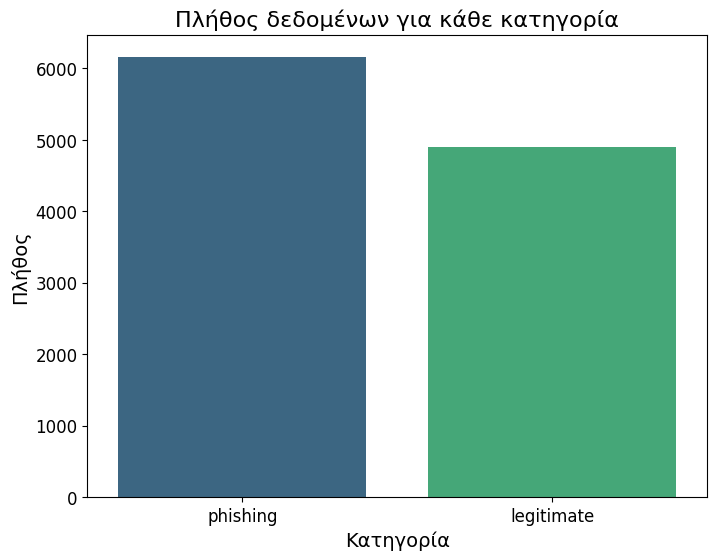

In [ ]:

# Υποθέτουμε ότι το 'df' είναι το DataFrame που περιέχει τα επεξεργασμένα δεδομένα
# Μετατροπή των τιμών της στήλης "Result" σε κατηγορίες 'phishing' και 'legitimate'
df['category'] = df['Result'].map({0: 'legitimate', 1: 'phishing'})
# Χρησιμοποιούμε τη μέθοδο map() για να αντιστοιχίσουμε αριθμητικές τιμές (0, 1) σε ετικέτες.

# Υπολογισμός των συχνοτήτων για κάθε κατηγορία
category_counts = df['category'].value_counts()
# Υπολογίζει πόσες φορές εμφανίζεται κάθε κατηγορία ('phishing' και 'legitimate').

# Υπολογισμός ποσοστών
total_count = category_counts.sum()  # Το συνολικό πλήθος των δεδομένων
category_percentages = (category_counts / total_count) * 100  # Υπολογισμός ποσοστών για κάθε κατηγορία

# Δημιουργία πίνακα με τα πλήθη και τα ποσοστά
category_data = pd.DataFrame({
    'Πλήθος': category_counts,
    'Ποσοστό': category_percentages
})

# Εκτύπωση του πίνακα με τα πλήθη και τα ποσοστά
print(category_data)

# Δημιουργία ραβδογράμματος για την απεικόνιση των συχνοτήτων
plt.figure(figsize=(8, 6))  # Ορισμός μεγέθους του γραφήματος
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
# Δημιουργία ραβδογράμματος με το seaborn. Οι κατηγορίες είναι στον άξονα x, ενώ οι συχνότητες στον y.
# Η παλέτα 'viridis' προσδίδει χρώματα στις ράβδους.

# Ρυθμίσεις για την εμφάνιση του γραφήματος
plt.title('Πλήθος δεδομένων για κάθε κατηγορία', fontsize=16)
# Τίτλος του γραφήματος με καθορισμένο μέγεθος γραμματοσειράς.
plt.xlabel('Κατηγορία', fontsize=14) # Ετικέτα για τον άξονα x με συγκεκριμένο μέγεθος γραμματοσειράς.
plt.ylabel('Πλήθος', fontsize=14) # Ετικέτα για τον άξονα y με συγκεκριμένο μέγεθος γραμματοσειράς.
plt.xticks(fontsize=12) # Μέγεθος γραμματοσειράς για τις ετικέτες του άξονα x.
plt.yticks(fontsize=12) # Μέγεθος γραμματοσειράς για τις ετικέτες του άξονα y.
plt.show() # Εμφάνιση του γραφήματος






--- Εξέταση διαφορετικών τιμών του k για το αρχείο: .old_processed.csv ---
k=1, Μέση Ακρίβεια: 0.9678
k=2, Μέση Ακρίβεια: 0.9406
k=3, Μέση Ακρίβεια: 0.9365
k=4, Μέση Ακρίβεια: 0.9271
k=5, Μέση Ακρίβεια: 0.9292
k=6, Μέση Ακρίβεια: 0.9243
k=7, Μέση Ακρίβεια: 0.9234
k=8, Μέση Ακρίβεια: 0.9287
k=9, Μέση Ακρίβεια: 0.9296
k=10, Μέση Ακρίβεια: 0.9296
k=11, Μέση Ακρίβεια: 0.9271
k=12, Μέση Ακρίβεια: 0.9259
k=13, Μέση Ακρίβεια: 0.9251
k=14, Μέση Ακρίβεια: 0.9214
k=15, Μέση Ακρίβεια: 0.9239
k=16, Μέση Ακρίβεια: 0.9210
k=17, Μέση Ακρίβεια: 0.9255
k=18, Μέση Ακρίβεια: 0.9235
k=19, Μέση Ακρίβεια: 0.9243
k=20, Μέση Ακρίβεια: 0.9231
k=21, Μέση Ακρίβεια: 0.9235
k=22, Μέση Ακρίβεια: 0.9198
k=23, Μέση Ακρίβεια: 0.9206
k=24, Μέση Ακρίβεια: 0.9214
k=25, Μέση Ακρίβεια: 0.9210
k=26, Μέση Ακρίβεια: 0.9218
k=27, Μέση Ακρίβεια: 0.9218
k=28, Μέση Ακρίβεια: 0.9153
k=29, Μέση Ακρίβεια: 0.9186
k=30, Μέση Ακρίβεια: 0.9182

Βέλτιστο k για το dataset .old_processed.csv: 1 με Μέση Ακρίβεια: 0.9678

--- Εξέταση διαφορ

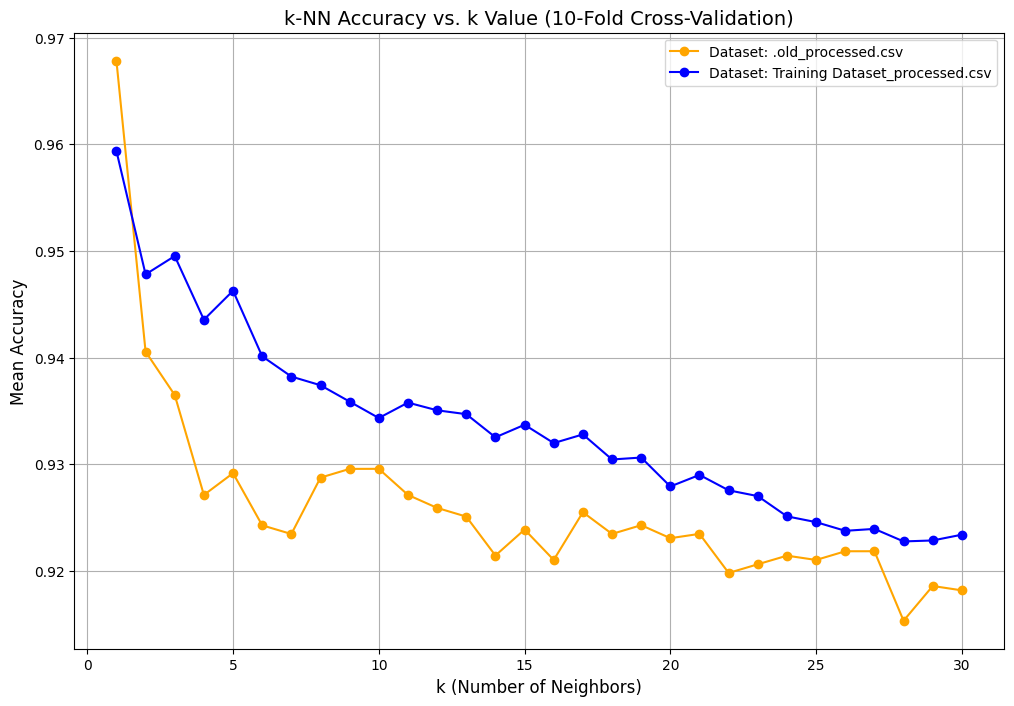

In [ ]:

# Φόρτωση των επεξεργασμένων datasets από τα αποθηκευμένα CSV
# Αντικαταστήστε τα filenames με τα πραγματικά ονόματα των αρχείων CSV
processed_datasets = {
    ".old_processed.csv": pd.read_csv(".old_processed.csv"),
    "Training Dataset_processed.csv": pd.read_csv("Training Dataset_processed.csv")
}

# Ορίστε τα δεδομένα
k_values = range(1, 31)  # Από το 1 έως το 30

# Ορίστε τα χρώματα πορτοκαλί και μπλε για τα δύο datasets
colors = ['orange', 'blue']  # Πρώτο χρώμα: πορτοκαλί, Δεύτερο χρώμα: μπλε

# Δημιουργία του γραφήματος
plt.figure(figsize=(12, 8))

for idx, (filename, df) in enumerate(processed_datasets.items()):
    print(f"\n--- Εξέταση διαφορετικών τιμών του k για το αρχείο: {filename} ---")

    # Διαχωρισμός χαρακτηριστικών (X) και στόχου (y)
    X = df.iloc[:, :-1].values  # Χαρακτηριστικά (όλα εκτός από τη στήλη στόχου)
    y = df.iloc[:, -1].values   # Στόχος (τελευταία στήλη)
    mean_accuracies = []

    for k in k_values:
        knn_model = KNeighborsClassifier(n_neighbors=k)
        knn_scores = cross_val_score(knn_model, X, y, cv=10, scoring='accuracy')  # 10-fold Cross-Validation
        mean_accuracy = knn_scores.mean()
        mean_accuracies.append(mean_accuracy)
        print(f"k={k}, Μέση Ακρίβεια: {mean_accuracy:.4f}")

    # Επιλογή χρώματος (πορτοκαλί για το πρώτο, μπλε για το δεύτερο)
    color = colors[idx % len(colors)]  # Επιλέγουμε το χρώμα, επαναλαμβάνοντας αν χρειαστεί
    plt.plot(k_values, mean_accuracies, marker='o', label=f'Dataset: {filename}', color=color)

    # Εύρεση του καλύτερου k
    best_k = k_values[np.argmax(mean_accuracies)]
    best_accuracy = max(mean_accuracies)
    print(f"\nΒέλτιστο k για το dataset {filename}: {best_k} με Μέση Ακρίβεια: {best_accuracy:.4f}")

# Σχεδιασμός του διαγράμματος
plt.xlabel('k (Number of Neighbors)', fontsize=12)
plt.ylabel('Mean Accuracy', fontsize=12)
plt.title('k-NN Accuracy vs. k Value (10-Fold Cross-Validation)', fontsize=14)
plt.grid(True)
plt.legend(fontsize=10)
plt.show()














--- Επεξεργασία και Αξιολόγηση για το αρχείο: .old_processed.csv ---


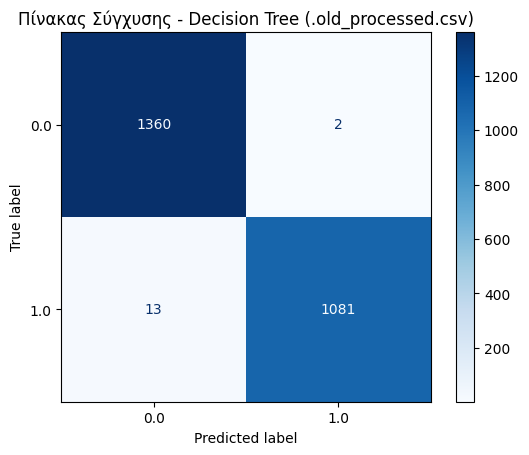

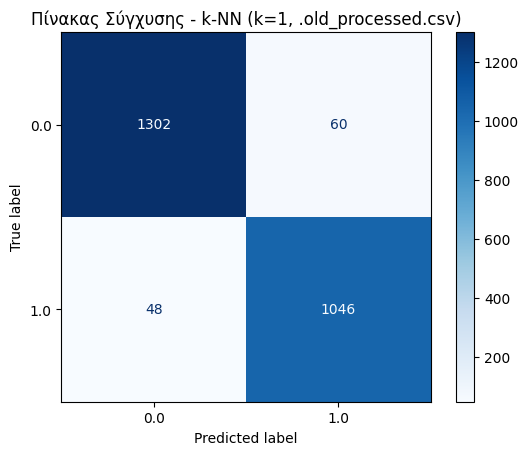


--- Επεξεργασία και Αξιολόγηση για το αρχείο: Training Dataset_processed.csv ---


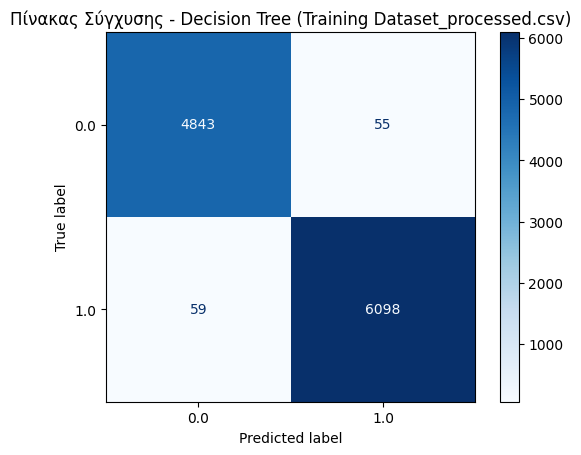

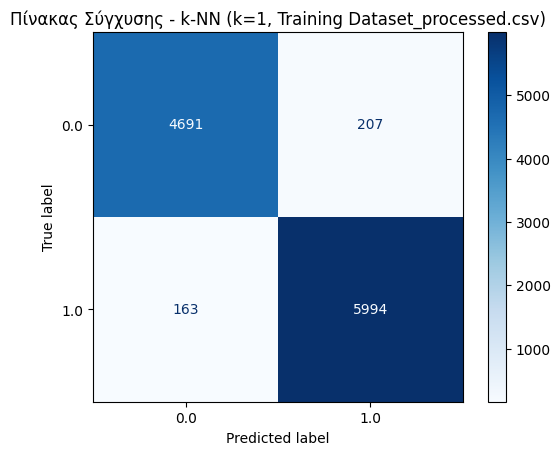

In [ ]:

import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Υποθέτουμε ότι τα δεδομένα είναι αποθηκευμένα στη μεταβλητή processed_datasets
# processed_datasets = {'dataset1': df1, 'dataset2': df2, ...}

# Ορισμός του αριθμού γειτόνων για το k-NN
best_k = 1 # Μπορείς να το τροποποιήσεις με το καλύτερο k που βρήκες προηγουμένως

# Βρόχος για κάθε dataset
for filename, df in processed_datasets.items():
    print(f"\n--- Επεξεργασία και Αξιολόγηση για το αρχείο: {filename} ---")

    # Διαχωρισμός χαρακτηριστικών και στόχου
    X = df.iloc[:, :-1].values  # Χαρακτηριστικά
    y = df.iloc[:, -1].values   # Στόχος


    # Δημιουργία Πίνακα Σύγχυσης για το Decision Tree
    dt_model.fit(X, y)  # Εκπαίδευση για να δημιουργηθεί ο πίνακας σύγχυσης
    y_pred_dt = dt_model.predict(X)  # Προβλέψεις
    cm_dt = confusion_matrix(y, y_pred_dt)
    disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=dt_model.classes_)
    disp_dt.plot(cmap=plt.cm.Blues)
    plt.title(f"Πίνακας Σύγχυσης - Decision Tree ({filename})")
    plt.show()

    # Δημιουργία Πίνακα Σύγχυσης για το k-NN
    knn_model.fit(X, y)  # Εκπαίδευση για να δημιουργηθεί ο πίνακας σύγχυσης
    y_pred_knn = knn_model.predict(X)  # Προβλέψεις
    cm_knn = confusion_matrix(y, y_pred_knn)
    disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=knn_model.classes_)
    disp_knn.plot(cmap=plt.cm.Blues)
    plt.title(f"Πίνακας Σύγχυσης - k-NN (k={best_k}, {filename})")
    plt.show()


